**This notebook provides examples of how to reproduce all major figures in this manuscript.**

In [1]:
import re
import json
import pickle
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import mean_absolute_error, r2_score

from inference.sina_plot import sinaplot
from inference.periodic_trends import periodic_trends_plotter
from inference.plot_utils import flatten, get_property, get_relative_vals, plot_pca_embedding, plot_pca_embedding_additional


plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams["xtick.major.size"] = 4
plt.rcParams["ytick.major.size"] = 4
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.major.width"] = 2
plt.rcParams['text.usetex'] = False
plt.rc('lines', linewidth=3, color='g')
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['mathtext.fontset'] = 'dejavusans'

/home/jypeng/miniconda3/envs/Perovskite_ML_Environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Main_dataset_statistics

In [2]:
edge_data = pd.read_json('data/edge_dataset.json')
print('Number of ternary perovskite structures in the dataset:', edge_data.shape[0])

dataset_names = ['training_set', 'validation_set', 'test_set', 'holdout_set_B_sites', 'holdout_set_series']
for i in range(len(dataset_names)):
    if i == 0:
        temp_df = pd.read_json('data/'+dataset_names[i]+'.json')
    else:
        temp_df = pd.concat([temp_df, pd.read_json('data/'+dataset_names[i]+'.json')], ignore_index=True)
quaternary_count = 0
quinary_count = 0
for i in range(len(temp_df)):
    num_elements = len(temp_df.iloc[i].composition["sites"]['A']) + len(temp_df.iloc[i].composition["sites"]['B']) + len(temp_df.iloc[i].composition["sites"]['X'])
    if num_elements == 4:
        quaternary_count += 1
    elif num_elements == 5:
        quinary_count += 1
    else:
        raise ValueError('Number of elements in the compound ' + temp_df.iloc[i].composition["formula"] + ' is not 4 or 5')
print('Number of quaternary perovskite structures in the dataset:', quaternary_count)
print('Number of quinary perovskite structures in the dataset:', quinary_count)

Number of ternary perovskite structures in the dataset: 2659
Number of quaternary perovskite structures in the dataset: 2328
Number of quinary perovskite structures in the dataset: 5290


In [3]:
all_data_df = pd.concat([temp_df, edge_data], ignore_index=True)
A_site_counter = collections.Counter()
B_site_counter = collections.Counter()
for i in range(len(all_data_df)):
    for A_site in all_data_df.iloc[i].composition["sites"]["A"]:
        A_site_counter[A_site] += 1
    for B_site in all_data_df.iloc[i].composition["sites"]["B"]:
        B_site_counter[B_site] += 1

In [4]:
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

In [5]:
periodic_trends_plotter(counter=A_site_counter, cmap="cividis", width=800, height=400, output_filename='./figures/Main_dataset_statistics_A_stats.html')

INFO:bokeh.io.state:Session output file './figures/Main_dataset_statistics_A_stats.html' already exists, will be overwritten.


figure(id='p1005', ...)

In [6]:
periodic_trends_plotter(counter=B_site_counter, cmap="cividis", width=800, height=400, output_filename='./figures/Main_dataset_statistics_B_stats.html')

INFO:bokeh.io.state:Session output file './figures/Main_dataset_statistics_B_stats.html' already exists, will be overwritten.


figure(id='p1061', ...)

In [7]:
A_site_stoichiometry_counter = collections.Counter()
B_site_stoichiometry_counter = collections.Counter()
ordering_counter = collections.Counter()

for i in range(len(all_data_df)):
    if len(all_data_df.iloc[i].composition["sites"]["A"]) == 1 and len(all_data_df.iloc[i].composition["sites"]["B"]) == 1:
        A_site_stoichiometry_counter[0] += 1
        B_site_stoichiometry_counter[0] += 1
        ordering_counter[0] += 1
    else:
        A_0 = all_data_df.iloc[i].composition["sites"]["A"][0]
        A_0_stoichiometry = int(all_data_df.iloc[i].composition["composition"][A_0])
        if len(all_data_df.iloc[i].composition["sites"]["A"]) > 1:
            A_1 = all_data_df.iloc[i].composition["sites"]["A"][1]
            A_1_stoichiometry = int(all_data_df.iloc[i].composition["composition"][A_1])
        else:
            A_1_stoichiometry = 0
        assert A_0_stoichiometry + A_1_stoichiometry == 8
        A_site_stoichiometry_counter[4 - abs(4 - A_0_stoichiometry)] += 1

        B_0 = all_data_df.iloc[i].composition["sites"]["B"][0]
        B_0_stoichiometry = int(all_data_df.iloc[i].composition["composition"][B_0])
        if len(all_data_df.iloc[i].composition["sites"]["B"]) > 1:
            B_1 = all_data_df.iloc[i].composition["sites"]["B"][1]
            B_1_stoichiometry = int(all_data_df.iloc[i].composition["composition"][B_1])
        else:
            B_1_stoichiometry = 0
        assert B_0_stoichiometry + B_1_stoichiometry == 8
        B_site_stoichiometry_counter[4 - abs(4 - B_0_stoichiometry)] += 1

        ordering_count = min(len(all_data_df[all_data_df['formula'] == all_data_df.iloc[i]["formula"]]), 7)
        ordering_counter[ordering_count - 1] += 1

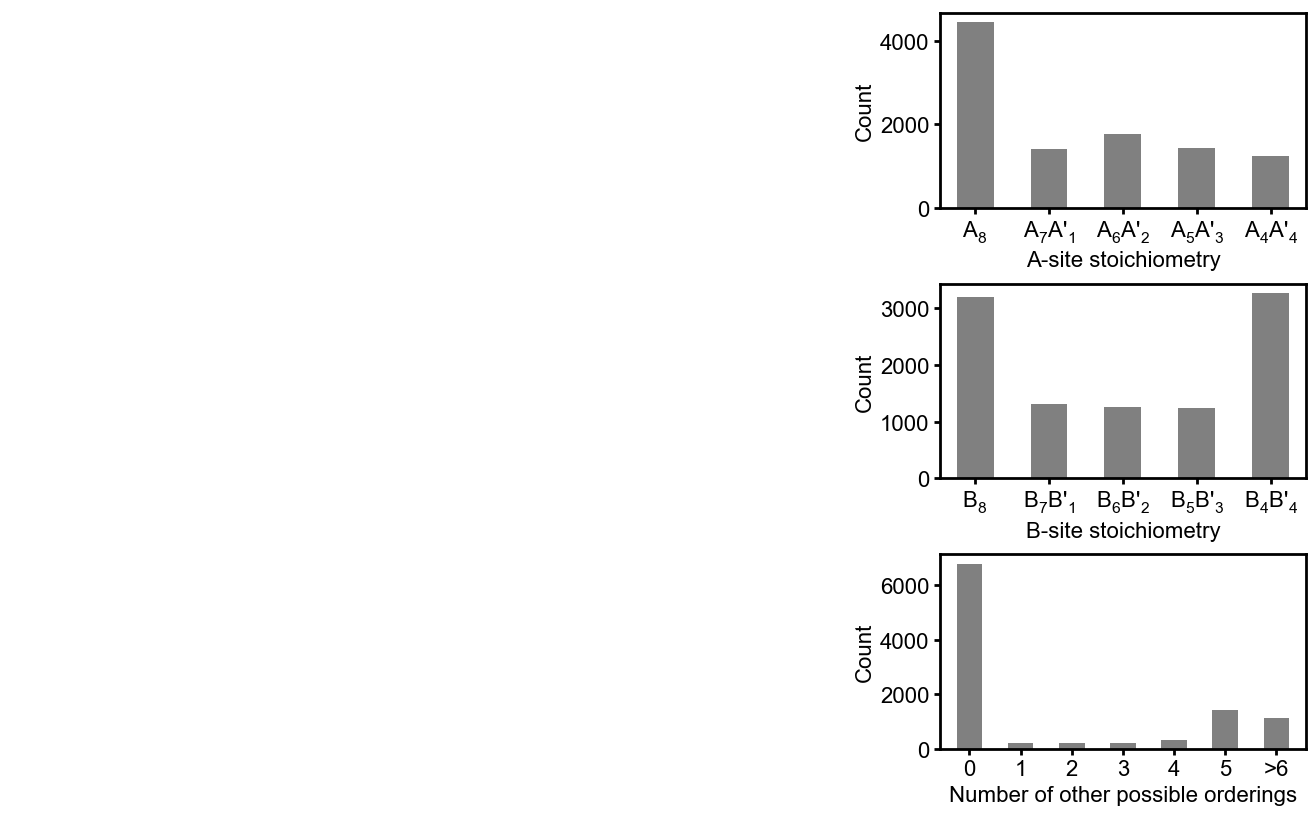

In [8]:
fig = plt.figure(figsize=(13, 8), constrained_layout=True)
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=[1.8, 1])

axes_r = subfig_r.subplots(nrows=3, ncols=1, gridspec_kw={'hspace': 0.05})

axes_r[0].bar(A_site_stoichiometry_counter.keys(), A_site_stoichiometry_counter.values(), width=0.5, color='grey')
axes_r[0].set_ylabel('Count')
axes_r[0].set_xlabel('A-site stoichiometry')
axes_r[0].set_xticks(range(0, 5))
axes_r[0].set_xticklabels(['A$_8$', 'A$_7$A\'$_1$', 'A$_6$A\'$_2$', 'A$_5$A\'$_3$', 'A$_4$A\'$_4$'])

axes_r[1].bar(B_site_stoichiometry_counter.keys(), B_site_stoichiometry_counter.values(), width=0.5, color='grey')
axes_r[1].set_ylabel('Count')
axes_r[1].set_xlabel('B-site stoichiometry')
axes_r[1].set_xticks(range(0, 5))
axes_r[1].set_xticklabels(['B$_8$', 'B$_7$B\'$_1$', 'B$_6$B\'$_2$', 'B$_5$B\'$_3$', 'B$_4$B\'$_4$'])

axes_r[2].bar(ordering_counter.keys(), ordering_counter.values(), width=0.5, color='grey')
axes_r[2].set_ylabel('Count')
axes_r[2].set_xlabel('Number of other possible orderings')
axes_r[2].set_xticks(range(0, 7))
axes_r[2].set_xticklabels(['0', '1', '2', '3', '4', '5', '>6'])

# plt.tight_layout()
plt.savefig('./figures/Main_dataset_statistics_bar.pdf', bbox_inches='tight')

# Main_compositional_dependence

In [9]:
ehull_CGCNN_unrelaxed_test_0 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_0/test_set_predictions.json")
ehull_CGCNN_unrelaxed_test_1 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_1/test_set_predictions.json")
ehull_CGCNN_unrelaxed_test_2 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_2/test_set_predictions.json")

ehull_e3nn_unrelaxed_test_0 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_0/test_set_predictions.json")
ehull_e3nn_unrelaxed_test_1 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_1/test_set_predictions.json")
ehull_e3nn_unrelaxed_test_2 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_2/test_set_predictions.json")

ehull_CGCNN_relaxed_test_0 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_0/test_set_predictions.json")
ehull_CGCNN_relaxed_test_1 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_1/test_set_predictions.json")
ehull_CGCNN_relaxed_test_2 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_2/test_set_predictions.json")

ehull_e3nn_relaxed_test_0 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_0/test_set_predictions.json")
ehull_e3nn_relaxed_test_1 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_1/test_set_predictions.json")
ehull_e3nn_relaxed_test_2 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_2/test_set_predictions.json")

In [10]:
ehull_CGCNN_unrelaxed_test_true = flatten(ehull_CGCNN_unrelaxed_test_0['dft_e_hull'])
ehull_e3nn_unrelaxed_test_true = flatten(ehull_e3nn_unrelaxed_test_0['dft_e_hull'])

ehull_CGCNN_unrelaxed_test_pred = (flatten(ehull_CGCNN_unrelaxed_test_0.predicted_dft_e_hull) + flatten(ehull_CGCNN_unrelaxed_test_1.predicted_dft_e_hull)+flatten(ehull_CGCNN_unrelaxed_test_2.predicted_dft_e_hull))/3.0
ehull_e3nn_unrelaxed_test_pred = (flatten(ehull_e3nn_unrelaxed_test_0.predicted_dft_e_hull) + flatten(ehull_e3nn_unrelaxed_test_1.predicted_dft_e_hull)+flatten(ehull_e3nn_unrelaxed_test_2.predicted_dft_e_hull))/3.0

ehull_CGCNN_relaxed_test_true = flatten(ehull_CGCNN_relaxed_test_0['dft_e_hull'])
ehull_e3nn_relaxed_test_true = flatten(ehull_e3nn_relaxed_test_0['dft_e_hull'])

ehull_CGCNN_relaxed_test_pred = (flatten(ehull_CGCNN_relaxed_test_0.predicted_dft_e_hull) + flatten(ehull_CGCNN_relaxed_test_1.predicted_dft_e_hull)+flatten(ehull_CGCNN_relaxed_test_2.predicted_dft_e_hull))/3.0
ehull_e3nn_relaxed_test_pred = (flatten(ehull_e3nn_relaxed_test_0.predicted_dft_e_hull) + flatten(ehull_e3nn_relaxed_test_1.predicted_dft_e_hull)+flatten(ehull_e3nn_relaxed_test_2.predicted_dft_e_hull))/3.0

In [11]:
CGCNN_unrelaxed, e3nn_unrelaxed = get_property("dft_e_hull", "unrelaxed")
CGCNN_relaxed, e3nn_relaxed = get_property("dft_e_hull", "relaxed")

dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN_TrainingFraction0.5
dft_e_hull_htvs_data_unrelaxed_CGCNN_TrainingFraction0.25
dft_e_hull_htvs_data_unrelaxed_CGCNN_TrainingFraction0.125
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn_TrainingFraction0.5
dft_e_hull_htvs_data_unrelaxed_e3nn_TrainingFraction0.25
dft_e_hull_htvs_data_unrelaxed_e3nn_TrainingFraction0.125
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN_TrainingFraction0.5
dft_e_hull_htvs_data_relaxed_CGCNN_TrainingFraction0.25
dft_e_hull_htvs_data_relaxed_CGCNN_TrainingFraction0.125
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn_TrainingFraction0.5
dft_e_hull_htvs_data_relaxed_e3nn_TrainingFraction0.25
dft_e_hull_htvs_data_relaxed_e3nn_TrainingFraction0.125


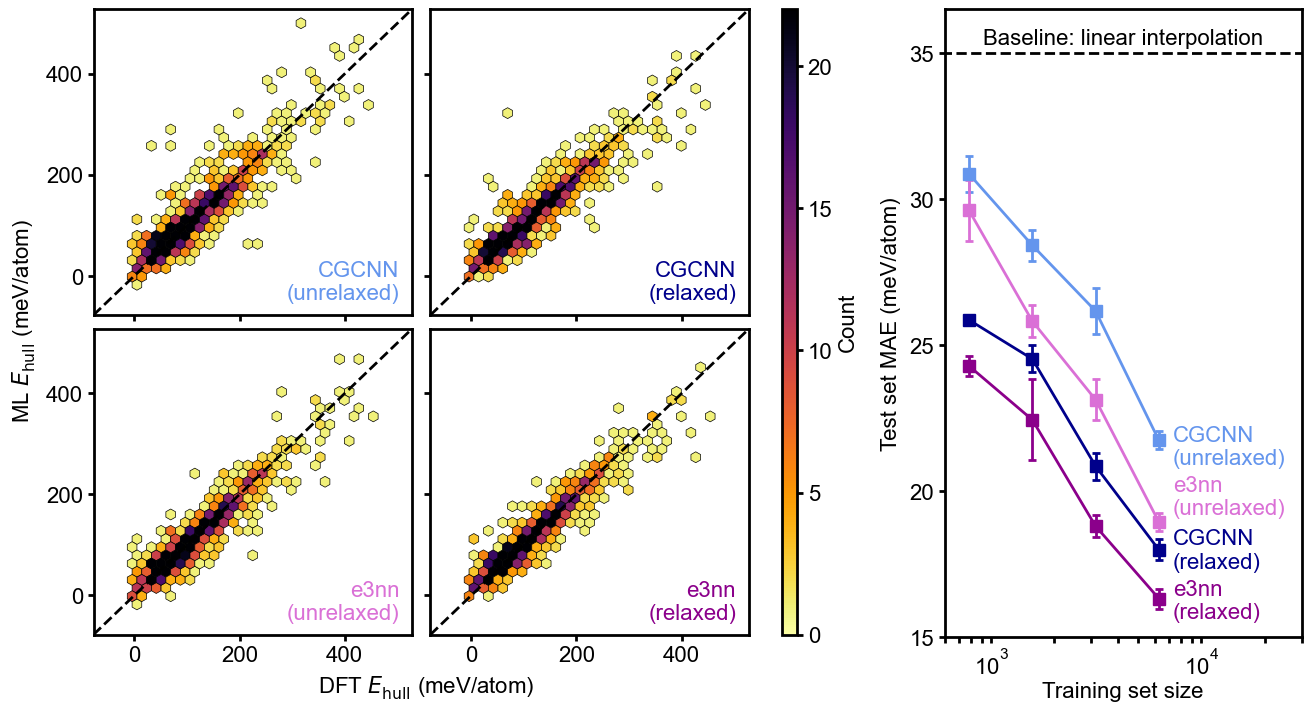

In [12]:
fig = plt.figure(figsize=(13, 7), constrained_layout=True)
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=[2, 1])

axes_l = subfig_l.subplots(nrows=2, ncols=2, sharex=True, sharey=True, gridspec_kw={'left': 0.3})
hex_cmap = 'inferno_r'
hex_gridsize = 30
hex_mincnt = 1
hex_edgecolors = 'black'
hex_linewidths = 0.5
hex_xylim = [-50, 500]
cbar_vmax = 22

axes_l[0][0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[0][1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[1][0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[1][1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)

axes_l[0][0].hexbin(
    ehull_CGCNN_unrelaxed_test_true*1000, ehull_CGCNN_unrelaxed_test_pred*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

axes_l[0][1].hexbin(
    ehull_e3nn_unrelaxed_test_true*1000, ehull_e3nn_unrelaxed_test_pred*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

axes_l[1][0].hexbin(
    ehull_CGCNN_relaxed_test_true*1000, ehull_CGCNN_relaxed_test_pred*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

hex_example = axes_l[1][1].hexbin(
    ehull_e3nn_relaxed_test_true*1000, ehull_e3nn_relaxed_test_pred*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

axes_l[0][0].text(0.96, 0.05, 'CGCNN\n(unrelaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[0][0].transAxes, color='cornflowerblue')
axes_l[1][0].text(0.96, 0.05, 'e3nn\n(unrelaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[1][0].transAxes, color='orchid')
axes_l[0][1].text(0.96, 0.05, 'CGCNN\n(relaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[0][1].transAxes, color='darkblue')
axes_l[1][1].text(0.96, 0.05, 'e3nn\n(relaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[1][1].transAxes, color='darkmagenta')

subfig_l.colorbar(hex_example, ax=axes_l, label='Count', ticks=np.arange(0, cbar_vmax+1, 5), aspect=40)
subfig_l.supxlabel('DFT $\mathit{E}_{\mathrm{hull}}$ (meV/atom)', x=0.49, fontsize=16)
subfig_l.supylabel('ML $\mathit{E}_{\mathrm{hull}}$ (meV/atom)', y=0.55, fontsize=16)

ax_r = subfig_r.subplots(nrows=1, ncols=1)
ax_r.set_xlabel('Training set size', labelpad=2)
ax_r.set_ylabel('Test set MAE (meV/atom)', labelpad=6)
ax_r.set_xscale('log')
ax_r.set_xlim(600, 30000)
ax_r.tick_params(which='minor', length=4, width=2)
ax_r_xticks = np.array([1, 0.5, 0.25, 0.125]) * 6276
ax_r.set_ylim(15, 36.5)
ax_r.set_yticks(np.arange(15, 40, 5))

ax_r.errorbar(ax_r_xticks, CGCNN_unrelaxed[0]*1000, yerr=CGCNN_unrelaxed[1]*1000, fmt='-s', color='cornflowerblue', markersize=8, linewidth=2, capsize=3, capthick=2)
ax_r.errorbar(ax_r_xticks, e3nn_unrelaxed[0]*1000, yerr=e3nn_unrelaxed[1]*1000, fmt='-s', color='orchid', markersize=8, linewidth=2, capsize=3, capthick=2)
ax_r.errorbar(ax_r_xticks, CGCNN_relaxed[0]*1000, yerr=CGCNN_relaxed[1]*1000, fmt='-s', color='darkblue', markersize=8, linewidth=2, capsize=3, capthick=2)
ax_r.errorbar(ax_r_xticks, e3nn_relaxed[0]*1000, yerr=e3nn_relaxed[1]*1000, fmt='-s', color='darkmagenta', markersize=8, linewidth=2, capsize=3, capthick=2)
ax_r.hlines(35, 0, 10**6, color='black', linestyle='--', linewidth=2)

ax_r.text(0.64, 0.275, 'CGCNN\n(unrelaxed)', color='cornflowerblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.64, 0.195, 'e3nn\n(unrelaxed)', color='orchid', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.64, 0.110, 'CGCNN\n(relaxed)', color='darkblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.64, 0.030, 'e3nn\n(relaxed)', color='darkmagenta', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.50, 0.945, 'Baseline: linear interpolation', color='black', fontsize=16, ha='center', transform=ax_r.transAxes)

# plt.tight_layout()
plt.savefig('./figures/Main_compositional_dependence.pdf', bbox_inches='tight')

# Main_ordering_dependence

In [13]:
ehull_CGCNN_unrelaxed_held_B_0 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_0/holdout_set_B_sites_predictions.json")
ehull_CGCNN_unrelaxed_held_B_1 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_1/holdout_set_B_sites_predictions.json")
ehull_CGCNN_unrelaxed_held_B_2 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_2/holdout_set_B_sites_predictions.json")

ehull_e3nn_unrelaxed_held_B_0 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_0/holdout_set_B_sites_predictions.json")
ehull_e3nn_unrelaxed_held_B_1 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_1/holdout_set_B_sites_predictions.json")
ehull_e3nn_unrelaxed_held_B_2 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_2/holdout_set_B_sites_predictions.json")

ehull_CGCNN_relaxed_held_B_0 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_0/holdout_set_B_sites_predictions.json")
ehull_CGCNN_relaxed_held_B_1 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_1/holdout_set_B_sites_predictions.json")
ehull_CGCNN_relaxed_held_B_2 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_2/holdout_set_B_sites_predictions.json")

ehull_e3nn_relaxed_held_B_0 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_0/holdout_set_B_sites_predictions.json")
ehull_e3nn_relaxed_held_B_1 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_1/holdout_set_B_sites_predictions.json")
ehull_e3nn_relaxed_held_B_2 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_2/holdout_set_B_sites_predictions.json")

In [14]:
ehull_CGCNN_unrelaxed_held_B_true = flatten(ehull_CGCNN_unrelaxed_held_B_0['dft_e_hull'])
ehull_e3nn_unrelaxed_held_B_true = flatten(ehull_e3nn_unrelaxed_held_B_0['dft_e_hull'])

ehull_CGCNN_unrelaxed_held_B_pred = (flatten(ehull_CGCNN_unrelaxed_held_B_0.predicted_dft_e_hull) + flatten(ehull_CGCNN_unrelaxed_held_B_1.predicted_dft_e_hull)+flatten(ehull_CGCNN_unrelaxed_held_B_2.predicted_dft_e_hull))/3.0
ehull_e3nn_unrelaxed_held_B_pred = (flatten(ehull_e3nn_unrelaxed_held_B_0.predicted_dft_e_hull) + flatten(ehull_e3nn_unrelaxed_held_B_1.predicted_dft_e_hull)+flatten(ehull_e3nn_unrelaxed_held_B_2.predicted_dft_e_hull))/3.0

ehull_CGCNN_relaxed_held_B_true = flatten(ehull_CGCNN_relaxed_held_B_0['dft_e_hull'])
ehull_e3nn_relaxed_held_B_true = flatten(ehull_e3nn_relaxed_held_B_0['dft_e_hull'])

ehull_CGCNN_relaxed_held_B_pred = (flatten(ehull_CGCNN_relaxed_held_B_0.predicted_dft_e_hull) + flatten(ehull_CGCNN_relaxed_held_B_1.predicted_dft_e_hull)+flatten(ehull_CGCNN_relaxed_held_B_2.predicted_dft_e_hull))/3.0
ehull_e3nn_relaxed_held_B_pred = (flatten(ehull_e3nn_relaxed_held_B_0.predicted_dft_e_hull) + flatten(ehull_e3nn_relaxed_held_B_1.predicted_dft_e_hull)+flatten(ehull_e3nn_relaxed_held_B_2.predicted_dft_e_hull))/3.0

In [15]:
diffs_dft = get_relative_vals(ehull_e3nn_unrelaxed_held_B_0, ehull_e3nn_unrelaxed_held_B_0.dft_e_hull)

diffs_e3nn_unrelaxed = get_relative_vals(ehull_e3nn_unrelaxed_held_B_0, ehull_e3nn_unrelaxed_held_B_pred)
diffs_e3nn_relaxed = get_relative_vals(ehull_e3nn_relaxed_held_B_0, ehull_e3nn_relaxed_held_B_pred)

diffs_CGCNN_unrelaxed = get_relative_vals(ehull_CGCNN_unrelaxed_held_B_0, ehull_CGCNN_unrelaxed_held_B_pred)
diffs_CGCNN_relaxed = get_relative_vals(ehull_CGCNN_relaxed_held_B_0, ehull_CGCNN_relaxed_held_B_pred)

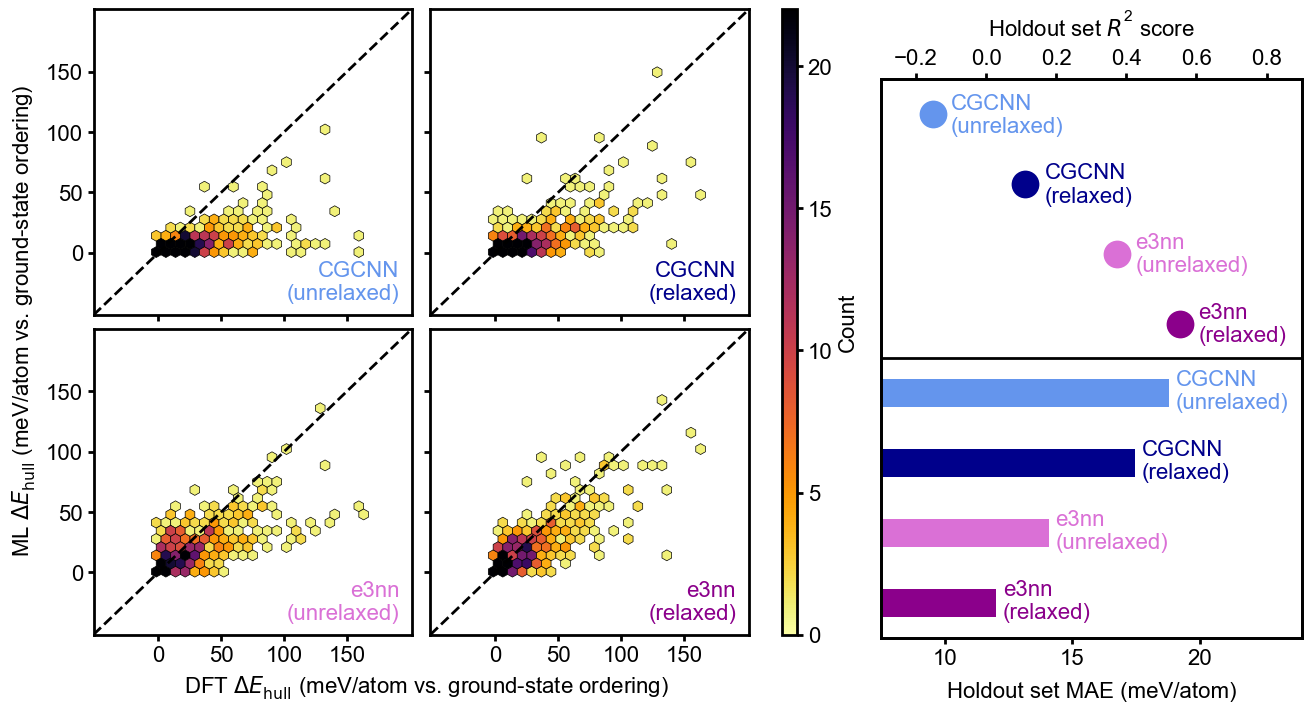

In [16]:
fig = plt.figure(figsize=(13, 7), constrained_layout=True)
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=[2, 1])

axes_l = subfig_l.subplots(nrows=2, ncols=2, sharex=True, sharey=True, gridspec_kw={'left': 0.3})
hex_cmap = 'inferno_r'
hex_gridsize = 30
hex_mincnt = 1
hex_edgecolors = 'black'
hex_linewidths = 0.5
hex_xylim = [-40, 190]
cbar_vmax = 22

axes_l[0][0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[1][0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[0][1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[1][1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)

axes_l[0][0].hexbin(
    diffs_dft*1000, diffs_CGCNN_unrelaxed*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

axes_l[1][0].hexbin(
    diffs_dft*1000, diffs_e3nn_unrelaxed*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

axes_l[0][1].hexbin(
    diffs_dft*1000, diffs_CGCNN_relaxed*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

hex_example = axes_l[1][1].hexbin(
    diffs_dft*1000, diffs_e3nn_relaxed*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)

axes_l[0][0].text(0.96, 0.05, 'CGCNN\n(unrelaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[0][0].transAxes, color='cornflowerblue')
axes_l[1][0].text(0.96, 0.05, 'e3nn\n(unrelaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[1][0].transAxes, color='orchid')
axes_l[0][1].text(0.96, 0.05, 'CGCNN\n(relaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[0][1].transAxes, color='darkblue')
axes_l[1][1].text(0.96, 0.05, 'e3nn\n(relaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[1][1].transAxes, color='darkmagenta')

axes_l[0][0].set_yticks(np.arange(0, hex_xylim[1], 50))
axes_l[0][0].set_xticks(np.arange(0, hex_xylim[1], 50))
subfig_l.colorbar(hex_example, ax=axes_l, label='Count', ticks=np.arange(0, cbar_vmax+1, 5), aspect=40)
subfig_l.supxlabel('DFT $\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom vs. ground-state ordering)', x=0.49, fontsize=16)
subfig_l.supylabel('ML $\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom vs. ground-state ordering)', y=0.55, fontsize=16)

ax_r = subfig_r.subplots(nrows=1, ncols=1)
ax_r_yaxis = ax_r.get_yaxis()
ax_r_yaxis.set_visible(False)
ax_r.set_xlabel('Holdout set MAE (meV/atom)', labelpad=9)
ax_r.set_xlim(7.5, 24)
ax_r.set_ylim(-4, 4)
ax_r.set_xticks(np.arange(10, 21, 5))

ax_r.barh(y=-0.5, width=mean_absolute_error(diffs_dft, diffs_CGCNN_unrelaxed)*1000, height=0.4, color='cornflowerblue')
ax_r.barh(y=-1.5, width=mean_absolute_error(diffs_dft, diffs_CGCNN_relaxed)*1000, height=0.4, color='darkblue')
ax_r.barh(y=-2.5, width=mean_absolute_error(diffs_dft, diffs_e3nn_unrelaxed)*1000, height=0.4, color='orchid')
ax_r.barh(y=-3.5, width=mean_absolute_error(diffs_dft, diffs_e3nn_relaxed)*1000, height=0.4, color='darkmagenta')

ax_r_twiny = ax_r.twiny()
ax_r_twiny.set_xlabel('Holdout set $\mathit{R}^2$ score', labelpad=9)
ax_r_twiny.set_xlim(-0.3, 0.9)
ax_r_twiny.set_xticks(np.arange(-0.2, 0.9, 0.2))

ax_r_twiny.plot(r2_score(diffs_dft, diffs_CGCNN_unrelaxed), 3.5, 'o', markersize=20, markeredgecolor='black', markeredgewidth=0, color='cornflowerblue')
ax_r_twiny.plot(r2_score(diffs_dft, diffs_CGCNN_relaxed), 2.5, 'o', markersize=20, markeredgecolor='black', markeredgewidth=0, color='darkblue')
ax_r_twiny.plot(r2_score(diffs_dft, diffs_e3nn_unrelaxed), 1.5, 'o', markersize=20, markeredgecolor='black', markeredgewidth=0, color='orchid')
ax_r_twiny.plot(r2_score(diffs_dft, diffs_e3nn_relaxed), 0.5, 'o', markersize=20, markeredgecolor='black', markeredgewidth=0, color='darkmagenta')

ax_r.hlines(0, 0, 100, color='black', linestyle='-', linewidth=2)

ax_r.text(0.165, 0.905, 'CGCNN\n(unrelaxed)', color='cornflowerblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.390, 0.780, 'CGCNN\n(relaxed)', color='darkblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.605, 0.655, 'e3nn\n(unrelaxed)', color='orchid', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.755, 0.530, 'e3nn\n(relaxed)', color='darkmagenta', fontsize=16, ha='left', transform=ax_r.transAxes)

ax_r.text(0.700, 0.410, 'CGCNN\n(unrelaxed)', color='cornflowerblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.620, 0.285, 'CGCNN\n(relaxed)', color='darkblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.415, 0.160, 'e3nn\n(unrelaxed)', color='orchid', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.290, 0.035, 'e3nn\n(relaxed)', color='darkmagenta', fontsize=16, ha='left', transform=ax_r.transAxes)

# plt.tight_layout()
plt.savefig('./figures/Main_ordering_dependence.pdf', bbox_inches='tight')

# Main_ordering_rationale

dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn


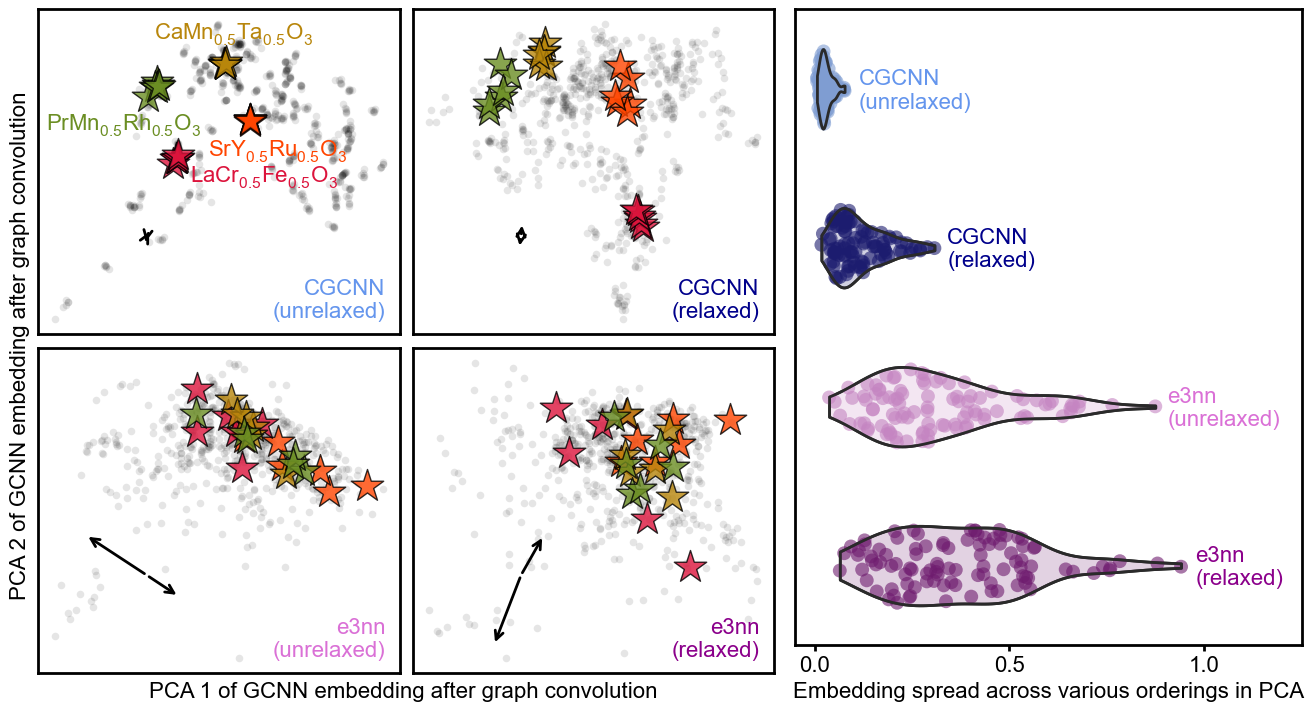

In [17]:
fig = plt.figure(figsize=(13, 7), constrained_layout=True)
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=[1.5, 1])

model_types = ["CGCNN", "e3nn"]
struct_types = ["unrelaxed", "relaxed"]

pca_spread = {}
for model_type in model_types:
    pca_spread[model_type] = {}
    for struct_type in struct_types:
        pca_spread[model_type][struct_type] = None

axes_l = subfig_l.subplots(nrows=2, ncols=2, gridspec_kw={'left': 0.3, 'bottom': 0.6, 'hspace': 0.04})
for i in range(2):
    for j in range(2):
        ax_l_yaxis = axes_l[i][j].get_yaxis()
        ax_l_xaxis = axes_l[i][j].get_xaxis()
        ax_l_yaxis.set_visible(False)
        ax_l_xaxis.set_visible(False)
        pca_spread[model_types[i]][struct_types[j]] = plot_pca_embedding(axes_l[i][j], model_types[i], struct_types[j], highlight=True)
        
axes_l[0][0].text(0.96, 0.05, 'CGCNN\n(unrelaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[0][0].transAxes, color='cornflowerblue')
axes_l[1][0].text(0.96, 0.05, 'e3nn\n(unrelaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[1][0].transAxes, color='orchid')
axes_l[0][1].text(0.96, 0.05, 'CGCNN\n(relaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[0][1].transAxes, color='darkblue')
axes_l[1][1].text(0.96, 0.05, 'e3nn\n(relaxed)', horizontalalignment='right', fontsize=16, transform=axes_l[1][1].transAxes, color='darkmagenta')

axes_l[0][0].text(0.47, 0.55, 'SrY$_{0.5}$Ru$_{0.5}$O$_3$', horizontalalignment='left', fontsize=16, transform=axes_l[0][0].transAxes, color='orangered')
axes_l[0][0].text(0.42, 0.47, 'LaCr$_{0.5}$Fe$_{0.5}$O$_3$', horizontalalignment='left', fontsize=16, transform=axes_l[0][0].transAxes, color='crimson')
axes_l[0][0].text(0.32, 0.91, 'CaMn$_{0.5}$Ta$_{0.5}$O$_3$', horizontalalignment='left', fontsize=16, transform=axes_l[0][0].transAxes, color='darkgoldenrod')
axes_l[0][0].text(0.02, 0.63, 'PrMn$_{0.5}$Rh$_{0.5}$O$_3$', horizontalalignment='left', fontsize=16, transform=axes_l[0][0].transAxes, color='olivedrab')
subfig_l.supxlabel('PCA 1 of GCNN embedding after graph convolution', x=0.515, fontsize=16)
subfig_l.supylabel('PCA 2 of GCNN embedding after graph convolution', y=0.515, fontsize=16)

ax_r = subfig_r.subplots(nrows=1, ncols=1)
ax_r_yaxis = ax_r.get_yaxis()
ax_r_yaxis.set_visible(False)
ax_r.set_xlim(-0.05, 1.25)
ax_r.set_xticks(np.arange(0, 1.25, 0.5))

pal = sns.color_palette(['cornflowerblue', 'darkblue', 'orchid', 'darkmagenta'])
sns.set_palette(pal)
pca_spread_df = pd.DataFrame(columns = ["category", "spread"])
for i in range(2):
    for j in range(2):
        for spread in pca_spread[model_types[i]][struct_types[j]]:
            pca_spread_df.loc[len(pca_spread_df.index)] = [2*i + j, spread]

sinaplot(y='category', x='spread', orient='h', data=pca_spread_df, width=0.5, cut=0, linewidth=2, violin_facealpha=0.1, saturation=0.6, point_size=10, point_facealpha=0.6, random_state=10)
ax_r.text(0.125, 0.845, 'CGCNN\n(unrelaxed)', color='cornflowerblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.300, 0.595, 'CGCNN\n(relaxed)', color='darkblue', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.735, 0.345, 'e3nn\n(unrelaxed)', color='orchid', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.text(0.790, 0.095, 'e3nn\n(relaxed)', color='darkmagenta', fontsize=16, ha='left', transform=ax_r.transAxes)
ax_r.set_ylim(3.5, -0.5)
ax_r.set_xlabel('Embedding spread across various orderings in PCA')

# plt.tight_layout()
plt.savefig('./figures/Main_ordering_rationale.pdf', bbox_inches='tight')

# Main_additional_generalizability

In [18]:
ehull_Painn_unrelaxed_test_0 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_unrelaxed_Painn/837609/best_0/test_set_predictions.json")
ehull_Painn_unrelaxed_test_1 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_unrelaxed_Painn/837609/best_1/test_set_predictions.json")
ehull_Painn_unrelaxed_test_2 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_unrelaxed_Painn/837609/best_2/test_set_predictions.json")

ehull_Painn_relaxed_test_0 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_relaxed_Painn/3/best_0/test_set_predictions.json")
ehull_Painn_relaxed_test_1 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_relaxed_Painn/3/best_1/test_set_predictions.json")
ehull_Painn_relaxed_test_2 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_relaxed_Painn/3/best_2/test_set_predictions.json")

ehull_Painn_unrelaxed_test_true = flatten(ehull_Painn_unrelaxed_test_0['dft_e_hull'])
ehull_Painn_unrelaxed_test_pred = (flatten(ehull_Painn_unrelaxed_test_0.predicted_dft_e_hull) + flatten(ehull_Painn_unrelaxed_test_1.predicted_dft_e_hull)+flatten(ehull_Painn_unrelaxed_test_2.predicted_dft_e_hull))/3.0

ehull_Painn_relaxed_test_true = flatten(ehull_Painn_relaxed_test_0['dft_e_hull'])
ehull_Painn_relaxed_test_pred = (flatten(ehull_Painn_relaxed_test_0.predicted_dft_e_hull) + flatten(ehull_Painn_relaxed_test_1.predicted_dft_e_hull)+flatten(ehull_Painn_relaxed_test_2.predicted_dft_e_hull))/3.0

ehull_Painn_unrelaxed_held_B_0 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_unrelaxed_Painn/837609/best_0/holdout_set_B_sites_predictions.json")
ehull_Painn_unrelaxed_held_B_1 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_unrelaxed_Painn/837609/best_1/holdout_set_B_sites_predictions.json")
ehull_Painn_unrelaxed_held_B_2 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_unrelaxed_Painn/837609/best_2/holdout_set_B_sites_predictions.json")

ehull_Painn_unrelaxed_held_B_true = flatten(ehull_Painn_unrelaxed_held_B_0['dft_e_hull'])
ehull_Painn_unrelaxed_held_B_pred = (flatten(ehull_Painn_unrelaxed_held_B_0.predicted_dft_e_hull) + flatten(ehull_Painn_unrelaxed_held_B_1.predicted_dft_e_hull)+flatten(ehull_Painn_unrelaxed_held_B_2.predicted_dft_e_hull))/3.0

diffs_dft = get_relative_vals(ehull_Painn_unrelaxed_held_B_0, ehull_Painn_unrelaxed_held_B_0.dft_e_hull)
diffs_Painn_unrelaxed = get_relative_vals(ehull_Painn_unrelaxed_held_B_0, ehull_Painn_unrelaxed_held_B_pred)

ehull_Painn_relaxed_held_B_0 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_relaxed_Painn/3/best_0/holdout_set_B_sites_predictions.json")
ehull_Painn_relaxed_held_B_1 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_relaxed_Painn/3/best_1/holdout_set_B_sites_predictions.json")
ehull_Painn_relaxed_held_B_2 = pd.read_json("./best_models/Painn/dft_e_hull_htvs_data_relaxed_Painn/3/best_2/holdout_set_B_sites_predictions.json")

ehull_Painn_relaxed_held_B_true = flatten(ehull_Painn_relaxed_held_B_0['dft_e_hull'])
ehull_Painn_relaxed_held_B_pred = (flatten(ehull_Painn_relaxed_held_B_0.predicted_dft_e_hull) + flatten(ehull_Painn_relaxed_held_B_1.predicted_dft_e_hull)+flatten(ehull_Painn_relaxed_held_B_2.predicted_dft_e_hull))/3.0

diffs_Painn_relaxed = get_relative_vals(ehull_Painn_relaxed_held_B_0, ehull_Painn_relaxed_held_B_pred)

In [19]:
ehull_CGCNN_unrelaxed_held_series_0 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_0/holdout_set_series_predictions.json")
ehull_CGCNN_unrelaxed_held_series_1 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_1/holdout_set_series_predictions.json")
ehull_CGCNN_unrelaxed_held_series_2 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_unrelaxed_CGCNN/837611/best_2/holdout_set_series_predictions.json")

ehull_e3nn_unrelaxed_held_series_0 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_0/holdout_set_series_predictions.json")
ehull_e3nn_unrelaxed_held_series_1 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_1/holdout_set_series_predictions.json")
ehull_e3nn_unrelaxed_held_series_2 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_unrelaxed_e3nn/837627/best_2/holdout_set_series_predictions.json")

ehull_CGCNN_relaxed_held_series_0 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_0/holdout_set_series_predictions.json")
ehull_CGCNN_relaxed_held_series_1 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_1/holdout_set_series_predictions.json")
ehull_CGCNN_relaxed_held_series_2 = pd.read_json("./best_models/CGCNN/dft_e_hull_htvs_data_relaxed_CGCNN/837612/best_2/holdout_set_series_predictions.json")

ehull_e3nn_relaxed_held_series_0 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_0/holdout_set_series_predictions.json")
ehull_e3nn_relaxed_held_series_1 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_1/holdout_set_series_predictions.json")
ehull_e3nn_relaxed_held_series_2 = pd.read_json("./best_models/e3nn/dft_e_hull_htvs_data_relaxed_e3nn/837628/best_2/holdout_set_series_predictions.json")

series_names = [
    'La$_\mathit{x}$Bi$_{1-\mathit{x}}$Cu$_{0.5}$Mo$_{0.5}$O$_3$',
    'K$_\mathit{x}$Ba$_{1-\mathit{x}}$Al$_{0.5}$Ti$_{0.5}$O$_3$',
    'Sr$_\mathit{x}$La$_{1-\mathit{x}}$Fe$_{0.5}$Co$_{0.5}$O$_3$',
    'Mg$_\mathit{x}$Pr$_{1-\mathit{x}}$V$_{0.5}$Ni$_{0.5}$O$_3$',
    'Y$_\mathit{x}$La$_{1-\mathit{x}}$Mg$_{0.5}$In$_{0.5}$O$_3$',
    'La$_\mathit{x}$Pr$_{1-\mathit{x}}$Ni$_{0.5}$Y$_{0.5}$O$_3$',
]

series_symbols = [
    [["La", "Bi"], ["Cu", "Mo"]],
    [["K",  "Ba"], ["Al", "Ti"]],
    [["Sr", "La"], ["Fe", "Co"]],
    [["Mg", "Pr"], ["V",  "Ni"]],
    [["Y",  "La"], ["Mg", "In"]],
    [["La", "Pr"], ["Ni",  "Y"]],
]

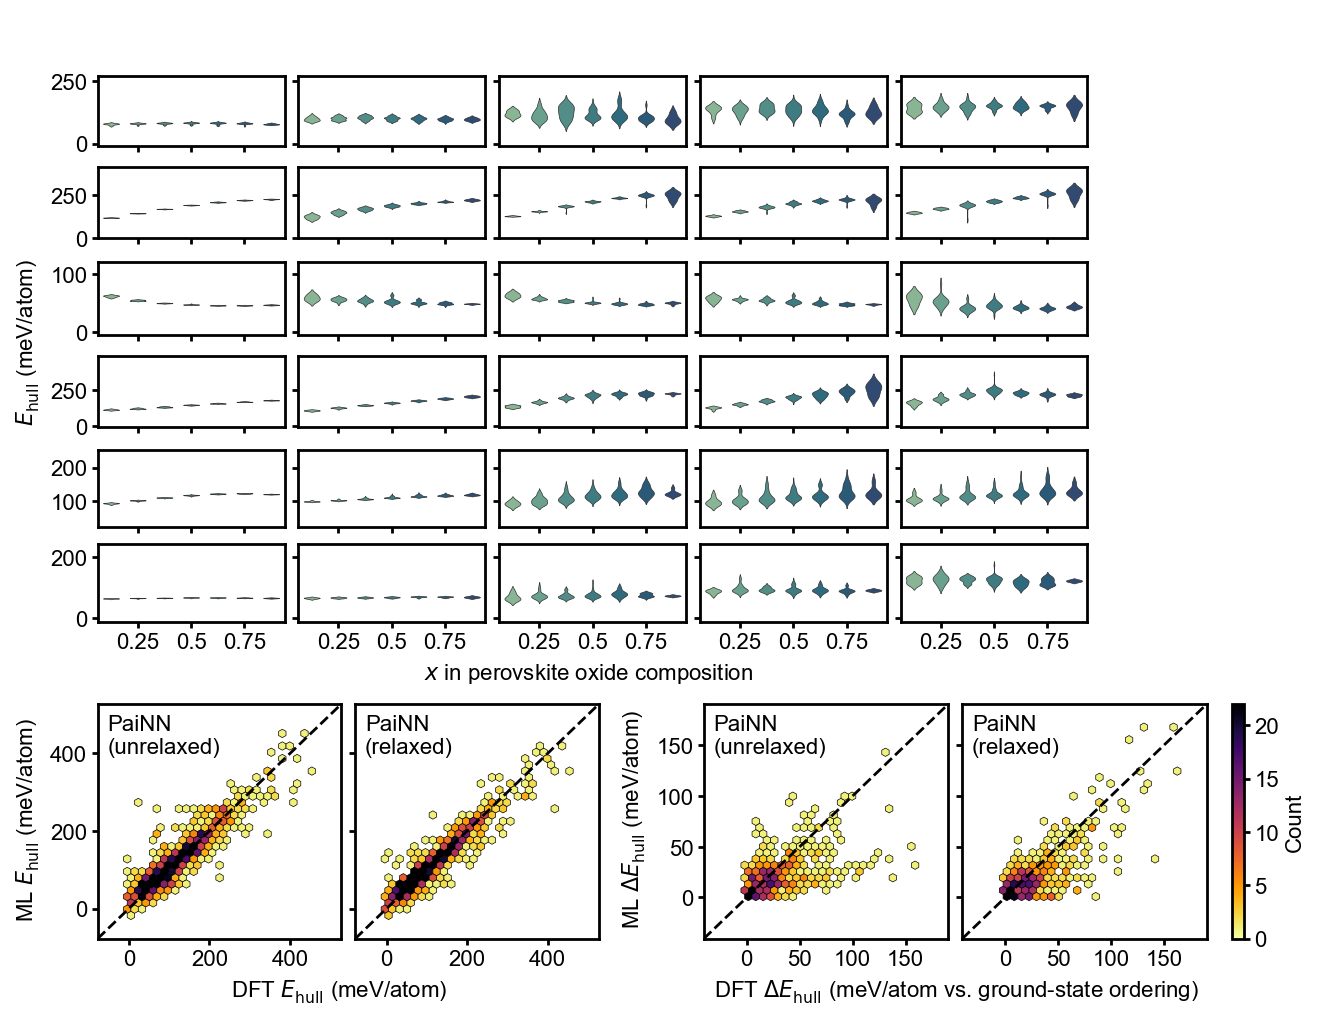

In [20]:
fig = plt.figure(figsize=(13, 10), constrained_layout=True)
(subfig_d, subfig_u) = fig.subfigures(nrows=2, ncols=1, height_ratios=[2.2, 1])

(subfig_l, subfig_r) = subfig_u.subfigures(nrows=1, ncols=2, width_ratios=[0.855, 1])
axes_l = subfig_l.subplots(nrows=1, ncols=2, sharex=True, sharey=True, gridspec_kw={'wspace': 0.00})
axes_r = subfig_r.subplots(nrows=1, ncols=2, sharex=True, sharey=True, gridspec_kw={'wspace': 0.00})

hex_cmap = 'inferno_r'
hex_gridsize = 30
hex_mincnt = 1
hex_edgecolors = 'black'
hex_linewidths = 0.5
cbar_vmax = 22

hex_xylim = [-50, 500]
axes_l[0].set_yticks(np.arange(0, hex_xylim[1], 200))
axes_l[0].set_xticks(np.arange(0, hex_xylim[1], 200))
axes_l[0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[0].hexbin(
    ehull_Painn_unrelaxed_test_true*1000, ehull_Painn_unrelaxed_test_pred*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_l[0].text(0.04, 0.79, 'PaiNN\n(unrelaxed)', horizontalalignment='left', fontsize=16, transform=axes_l[0].transAxes)
axes_l[1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[1].hexbin(
    ehull_Painn_unrelaxed_test_true*1000, ehull_Painn_relaxed_test_pred*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_l[1].text(0.04, 0.79, 'PaiNN\n(relaxed)', horizontalalignment='left', fontsize=16, transform=axes_l[1].transAxes)
subfig_l.supxlabel('DFT $\mathit{E}_{\mathrm{hull}}$ (meV/atom)', x=0.555, fontsize=16)
subfig_l.supylabel('ML $\mathit{E}_{\mathrm{hull}}$ (meV/atom)', y=0.615, fontsize=16)

hex_xylim = [-30, 180]
axes_r[0].set_yticks(np.arange(0, hex_xylim[1], 50))
axes_r[0].set_xticks(np.arange(0, hex_xylim[1], 50))
axes_r[0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_r[0].hexbin(
    diffs_dft*1000, diffs_Painn_unrelaxed*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_r[0].text(0.04, 0.79, 'PaiNN\n(unrelaxed)', horizontalalignment='left', fontsize=16, transform=axes_r[0].transAxes)
axes_r[1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
hex_example = axes_r[1].hexbin(
    diffs_dft*1000, diffs_Painn_relaxed*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_r[1].text(0.04, 0.79, 'PaiNN\n(relaxed)', horizontalalignment='left', fontsize=16, transform=axes_r[1].transAxes)
subfig_r.supxlabel('DFT $\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom vs. ground-state ordering)', x=0.490, fontsize=16)
subfig_r.supylabel('ML $\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom)', y=0.615, fontsize=16)
subfig_r.colorbar(hex_example, ax=axes_r, ticks=np.arange(0, cbar_vmax+1, 5), label='Count', aspect=20)

subfig_dd = subfig_d.subfigures(nrows=2, ncols=1, height_ratios=[0.08, 1])[1]
subfig_ddd = subfig_dd.subfigures(nrows=1, ncols=2, width_ratios=[1, 0.19])[0]
subfig_ddd.supxlabel('$\mathit{x}$ in perovskite oxide composition', x=0.535, fontsize=16)
subfig_ddd.supylabel('$\mathit{E}_{\mathrm{hull}}$ (meV/atom)', y=0.560, fontsize=16)
subfigs = subfig_ddd.subfigures(nrows=6, ncols=1, height_ratios=[1, 1, 1, 1, 1, 1.28])
axes = []

for i in range(len(subfigs)):
    axes.append(subfigs[i].subplots(nrows=1, ncols=5, sharex=True, sharey=True, gridspec_kw={'wspace': -0.1}))

    for j in range(len(axes[i])):
        if j == 1:
            temp_dfs = [ehull_e3nn_unrelaxed_held_series_0, ehull_e3nn_unrelaxed_held_series_1, ehull_e3nn_unrelaxed_held_series_2]            
        elif j == 2:
            temp_dfs = [ehull_CGCNN_relaxed_held_series_0, ehull_CGCNN_relaxed_held_series_1, ehull_CGCNN_relaxed_held_series_2]
        elif j == 3:
            temp_dfs = [ehull_e3nn_relaxed_held_series_0, ehull_e3nn_relaxed_held_series_1, ehull_e3nn_relaxed_held_series_2]
        else:
            temp_dfs = [ehull_CGCNN_unrelaxed_held_series_0, ehull_CGCNN_unrelaxed_held_series_1, ehull_CGCNN_unrelaxed_held_series_2]

        temp_dfs_cuts = []
        for k in range(len(temp_dfs)):
            temp_dfs_cuts.append(temp_dfs[k][
                temp_dfs[k].formula.str.contains(series_symbols[i][0][0]) &
                temp_dfs[k].formula.str.contains(series_symbols[i][0][1]) &
                temp_dfs[k].formula.str.contains(series_symbols[i][1][0]) &
                temp_dfs[k].formula.str.contains(series_symbols[i][1][1])
            ])

        if j == 4:
            target_prop = 'dft_e_hull'
        else:
            target_prop = 'predicted_dft_e_hull'

        to_plot = pd.DataFrame(columns=['conc', 'entry'])
        counter = 0
        for (framework, subdf_0), (_, subdf_1), (_, subdf_2) in zip(temp_dfs_cuts[0].groupby('framework'), temp_dfs_cuts[1].groupby('framework'), temp_dfs_cuts[2].groupby('framework')):
            conc = float(re.findall(r'%s(0\.\d+)' % series_symbols[i][0][0], framework)[0])
            subdf = (flatten(subdf_0[target_prop]) + flatten(subdf_1[target_prop]) + flatten(subdf_2[target_prop]))/3.0
            for entry in subdf:
                to_plot.loc[counter] = [conc, entry*1000]
                counter += 1
        
        sns.violinplot(x='conc', y='entry', data=to_plot, ax=axes[i][j], inner=None, scale="width", linewidth=0.5, palette='crest', width=0.6)
        
        axes[i][j].set(xlabel=None, ylabel=None)
        axes[i][j].set_xlim([-0.5, 6.5])
        axes[i][j].set_xticks(np.arange(1, 7, 2))

for i in range(len(subfigs)):
    if i != 5:
        for j in range(len(axes[i])):
            axes[i][j].set_xticklabels([])

    for j in range(len(axes[i])):
        ylim = axes[i][j].get_ylim()
        axes[i][j].set_ylim([ylim[0] - 0.05 * (ylim[1] - ylim[0]), ylim[1] + 0.05 * (ylim[1] - ylim[0])])
        
# plt.tight_layout()
plt.savefig('./figures/Main_additional_generalizability.pdf', bbox_inches='tight')

# Main_interatomic_potentials

In [21]:
holdout_set_B_sites = pd.read_json("./data/holdout_set_B_sites.json")
diffs_dft = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.dft_e_hull)
diffs_M3GNet = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.M3Gnet_relaxed_energy_per_atom)
diffs_CHGNet = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.CHGNet_relaxed_energy_per_atom_corrected)
diffs_MACE = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.MACE_relaxed_energy_per_atom)

/tmp/ipykernel_602731/146838025.py:67: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('./figures/Main_interatomic_potentials.pdf', bbox_inches='tight')
/home/jypeng/miniconda3/envs/Perovskite_ML_Environment/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


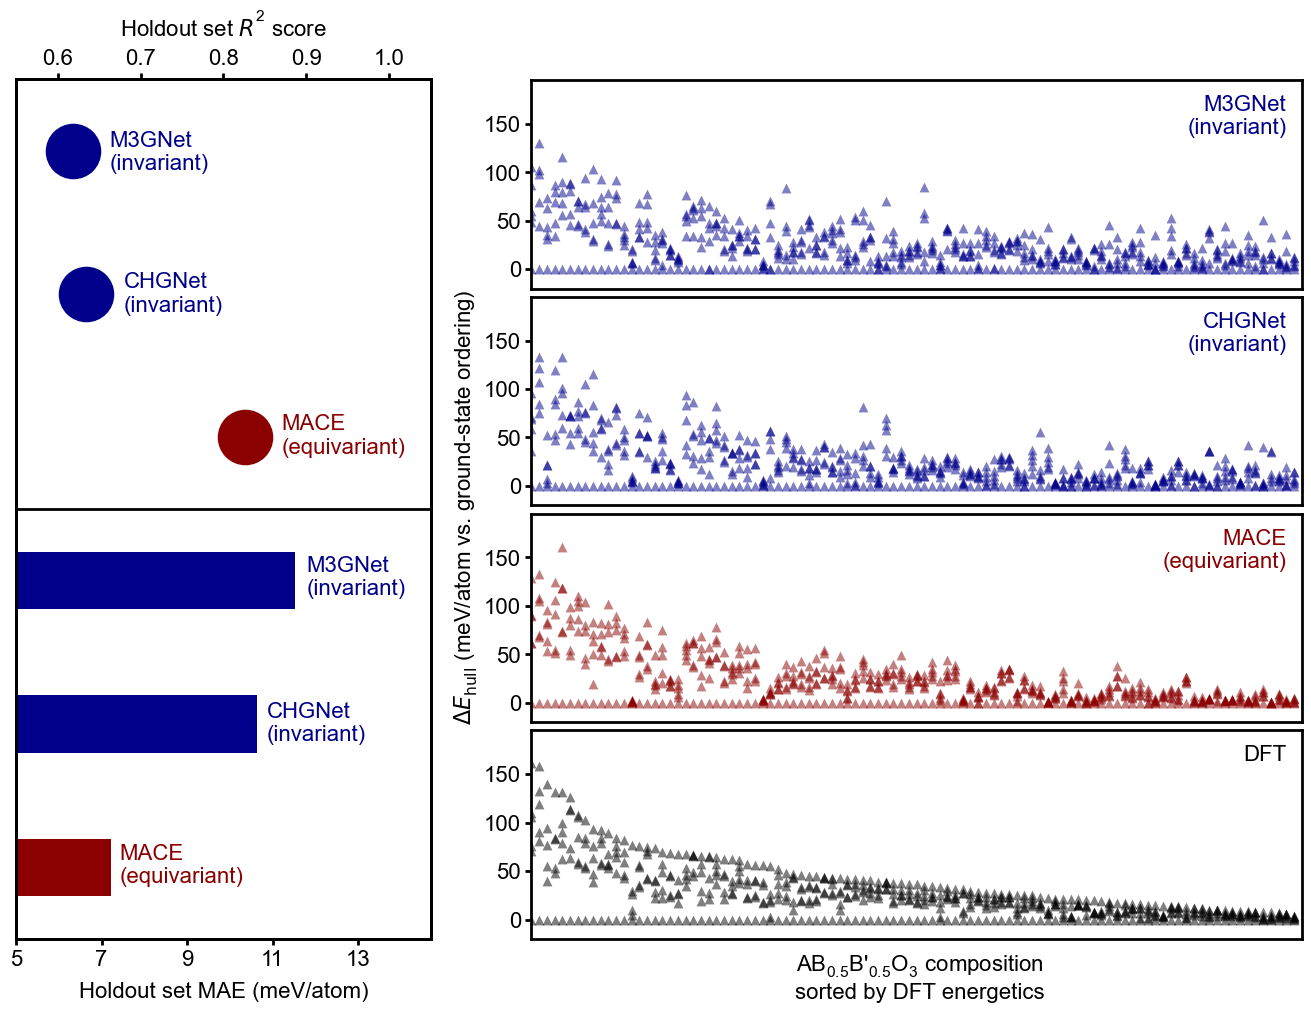

In [22]:
fig = plt.figure(figsize=(13, 10), constrained_layout=True)
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=[1, 2])

ax_l = subfig_l.subplots(nrows=1, ncols=1)
ax_l_yaxis = ax_l.get_yaxis()
ax_l_yaxis.set_visible(False)
ax_l.set_xlabel('Holdout set MAE (meV/atom)', labelpad=9)
ax_l.set_xlim(5, 14.7)
ax_l.set_ylim(-3, 3)
ax_l.set_xticks(np.arange(5, 15, 2))

ax_l.barh(y=-0.5, width=mean_absolute_error(diffs_dft, diffs_M3GNet)*1000, height=0.4, color='darkblue')
ax_l.barh(y=-1.5, width=mean_absolute_error(diffs_dft, diffs_CHGNet)*1000, height=0.4, color='darkblue')
ax_l.barh(y=-2.5, width=mean_absolute_error(diffs_dft, diffs_MACE)*1000, height=0.4, color='darkred')

ax_l_twiny = ax_l.twiny()
ax_l_twiny.set_xlabel('Holdout set $\mathit{R}^2$ score', labelpad=9)
ax_l_twiny.set_xlim(0.55, 1.05)
ax_l_twiny.set_xticks(np.arange(0.6, 1.05, 0.1))

ax_l_twiny.plot(r2_score(diffs_dft, diffs_M3GNet), 2.5, 'o', markersize=40, markeredgecolor='black', markeredgewidth=0, color='darkblue')
ax_l_twiny.plot(r2_score(diffs_dft, diffs_CHGNet), 1.5, 'o', markersize=40, markeredgecolor='black', markeredgewidth=0, color='darkblue')
ax_l_twiny.plot(r2_score(diffs_dft, diffs_MACE), 0.5, 'o', markersize=40, markeredgecolor='black', markeredgewidth=0, color='darkred')

ax_l.hlines(0, 0, 100, color='black', linestyle='-', linewidth=2)

ax_l.text(0.225, 0.895, 'M3GNet\n(invariant)', color='darkblue', fontsize=16, ha='left', transform=ax_l.transAxes)
ax_l.text(0.260, 0.730, 'CHGNet\n(invariant)', color='darkblue', fontsize=16, ha='left', transform=ax_l.transAxes)
ax_l.text(0.640, 0.565, 'MACE\n(equivariant)', color='darkred', fontsize=16, ha='left', transform=ax_l.transAxes)

ax_l.text(0.700, 0.400, 'M3GNet\n(invariant)', color='darkblue', fontsize=16, ha='left', transform=ax_l.transAxes)
ax_l.text(0.605, 0.230, 'CHGNet\n(invariant)', color='darkblue', fontsize=16, ha='left', transform=ax_l.transAxes)
ax_l.text(0.250, 0.065, 'MACE\n(equivariant)', color='darkred', fontsize=16, ha='left', transform=ax_l.transAxes)
 
axes_r = subfig_r.subplots(nrows=6, ncols=1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.05}, height_ratios=[0.29, 1, 1, 1, 1, 0])
subfig_r.supxlabel('AB$_{0.5}$B\'$_{0.5}$O$_3$ composition\nsorted by DFT energetics', x=0.55, fontsize=16)
subfig_r.supylabel('$\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom vs. ground-state ordering)', y=0.5, fontsize=16)

formulas = holdout_set_B_sites['formula'].unique()
energy_variations = []

for formula in formulas:
    holdout_set_B_sites_cut = holdout_set_B_sites[holdout_set_B_sites['formula'] == formula]
    energy_variations.append(np.nanmax(holdout_set_B_sites_cut['dft_energy_per_atom']) - np.nanmin(holdout_set_B_sites_cut['dft_energy_per_atom']))

energy_variations_sorted_indices = np.argsort(np.array(energy_variations))
panel_types = ['', 'M3Gnet_relaxed_energy_per_atom', 'CHGNet_relaxed_energy_per_atom_corrected', 'MACE_relaxed_energy_per_atom', 'dft_energy_per_atom', '']
panel_colors = ['', 'darkblue', 'darkblue', 'darkred', 'black', '']
panel_labels = ['', 'M3GNet\n(invariant)', 'CHGNet\n(invariant)', 'MACE\n(equivariant)', 'DFT', '']

for i in range(len(panel_types)):
    if (i == 0) or (i == 5):
        axes_r[i].set_axis_off()
    else:   
        axes_r[i].set_xlim(0, 100)
        axes_r[i].set_xticks([])
        axes_r[i].set_ylim(-20, 195)
        axes_r[i].set_yticks(np.arange(0, 195, 50))
        axes_r[i].text(0.98, 0.93, panel_labels[i], horizontalalignment='right', verticalalignment='top', color=panel_colors[i], fontsize=16, transform=axes_r[i].transAxes)
        for j in range(len(energy_variations_sorted_indices)):
            formula = formulas[energy_variations_sorted_indices[j]]
            holdout_set_B_sites_cut = holdout_set_B_sites[holdout_set_B_sites['formula'] == formula]
            for _, row in holdout_set_B_sites_cut.iterrows():
                axes_r[i].scatter((len(energy_variations_sorted_indices) - 1 - j), (row[panel_types[i]] - np.nanmin(holdout_set_B_sites_cut[panel_types[i]]))*1000, marker='^', linewidths=0, s=50, color=panel_colors[i], alpha=0.5)

# plt.tight_layout()
plt.savefig('./figures/Main_interatomic_potentials.pdf', bbox_inches='tight')

# SI_embedding_analysis

In [23]:
all_selected_forms = [
    'O24Rh4Sr8Ta4', 'Ni4O24Pb8Re4', 'Fe4La8Ni4O24', 'Co4O24Sr8Ta4',
    'Fe4La8O24Rh4', 'Ba8Mn4O24Ta4', 'Ca8Mn4O24Sb4', 'Cu4O24Pr8Ti4',
]

selected_forms_formatted = [
    'SrRh$_{0.5}$Ta$_{0.5}$O$_3$', 'PbNi$_{0.5}$Re$_{0.5}$O$_3$', 'LaFe$_{0.5}$Ni$_{0.5}$O$_3$', 'SrCo$_{0.5}$Ta$_{0.5}$O$_3$',
    'LaFe$_{0.5}$Rh$_{0.5}$O$_3$', 'BaMn$_{0.5}$Ta$_{0.5}$O$_3$', 'CaMn$_{0.5}$Sb$_{0.5}$O$_3$', 'PrTi$_{0.5}$Cu$_{0.5}$O$_3$',
]

dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN
dft_e_hull_htvs_data_unrelaxed_CGCNN


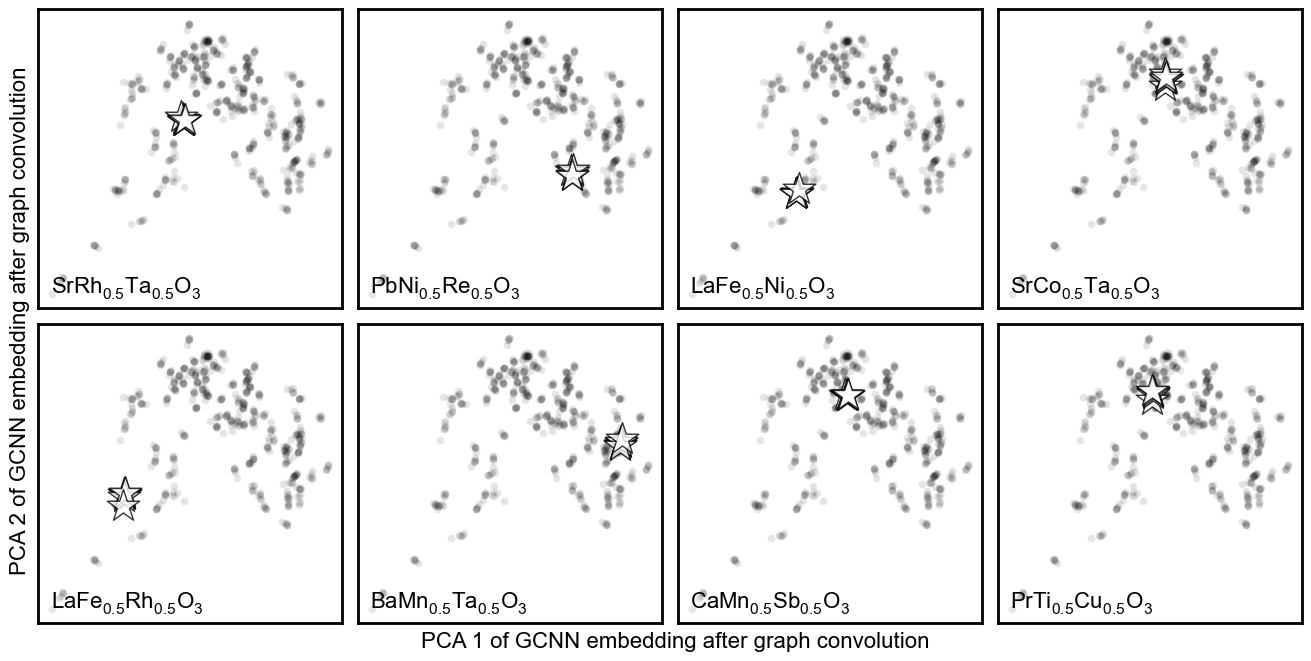

In [24]:
model_type = "CGCNN"
struct_type = "unrelaxed"

fig = plt.figure(figsize=(13, 6.5), constrained_layout=True)
axes = fig.subplots(nrows=2, ncols=4, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

fig.supxlabel('PCA 1 of GCNN embedding after graph convolution', x=0.515, fontsize=16)
fig.supylabel('PCA 2 of GCNN embedding after graph convolution', y=0.515, fontsize=16)

for i in range(2):
    for j in range(4):
        ax_yaxis = axes[i][j].get_yaxis()
        ax_xaxis = axes[i][j].get_xaxis()
        ax_yaxis.set_visible(False)
        ax_xaxis.set_visible(False)
        axes[i][j].text(0.04, 0.05, selected_forms_formatted[i*4+j], horizontalalignment='left', fontsize=16, transform=axes[i][j].transAxes, color='black')
        plot_pca_embedding_additional(axes[i][j], model_type, struct_type, all_selected_forms[i*4+j])

# plt.tight_layout()
plt.savefig('./figures/SI_embedding_analysis_cgcnn_unrelaxed.pdf', bbox_inches='tight')

dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN
dft_e_hull_htvs_data_relaxed_CGCNN


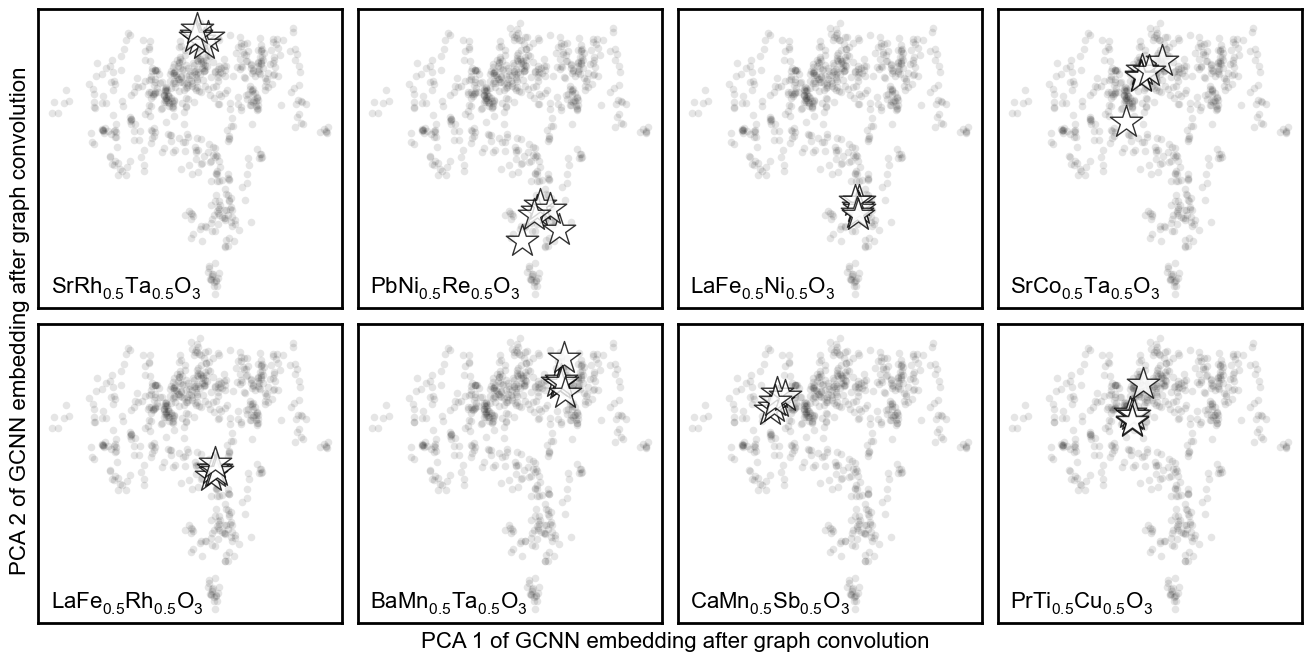

In [25]:
model_type = "CGCNN"
struct_type = "relaxed"

fig = plt.figure(figsize=(13, 6.5), constrained_layout=True)
axes = fig.subplots(nrows=2, ncols=4, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

fig.supxlabel('PCA 1 of GCNN embedding after graph convolution', x=0.515, fontsize=16)
fig.supylabel('PCA 2 of GCNN embedding after graph convolution', y=0.515, fontsize=16)

for i in range(2):
    for j in range(4):
        ax_yaxis = axes[i][j].get_yaxis()
        ax_xaxis = axes[i][j].get_xaxis()
        ax_yaxis.set_visible(False)
        ax_xaxis.set_visible(False)
        axes[i][j].text(0.04, 0.05, selected_forms_formatted[i*4+j], horizontalalignment='left', fontsize=16, transform=axes[i][j].transAxes, color='black')
        plot_pca_embedding_additional(axes[i][j], model_type, struct_type, all_selected_forms[i*4+j])

# plt.tight_layout()
plt.savefig('./figures/SI_embedding_analysis_cgcnn_relaxed.pdf', bbox_inches='tight')

dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn
dft_e_hull_htvs_data_unrelaxed_e3nn


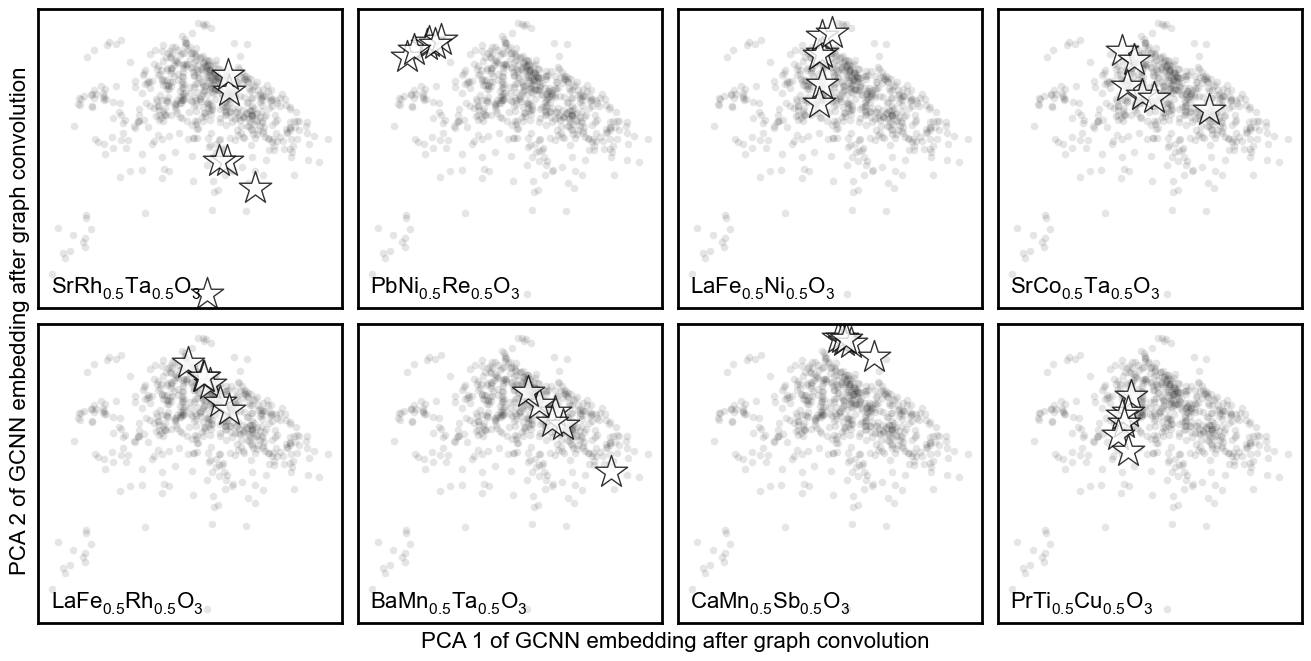

In [26]:
model_type = "e3nn"
struct_type = "unrelaxed"

fig = plt.figure(figsize=(13, 6.5), constrained_layout=True)
axes = fig.subplots(nrows=2, ncols=4, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

fig.supxlabel('PCA 1 of GCNN embedding after graph convolution', x=0.515, fontsize=16)
fig.supylabel('PCA 2 of GCNN embedding after graph convolution', y=0.515, fontsize=16)

for i in range(2):
    for j in range(4):
        ax_yaxis = axes[i][j].get_yaxis()
        ax_xaxis = axes[i][j].get_xaxis()
        ax_yaxis.set_visible(False)
        ax_xaxis.set_visible(False)
        axes[i][j].text(0.04, 0.05, selected_forms_formatted[i*4+j], horizontalalignment='left', fontsize=16, transform=axes[i][j].transAxes, color='black')
        plot_pca_embedding_additional(axes[i][j], model_type, struct_type, all_selected_forms[i*4+j])

# plt.tight_layout()
plt.savefig('./figures/SI_embedding_analysis_e3nn_unrelaxed.pdf', bbox_inches='tight')

dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn
dft_e_hull_htvs_data_relaxed_e3nn


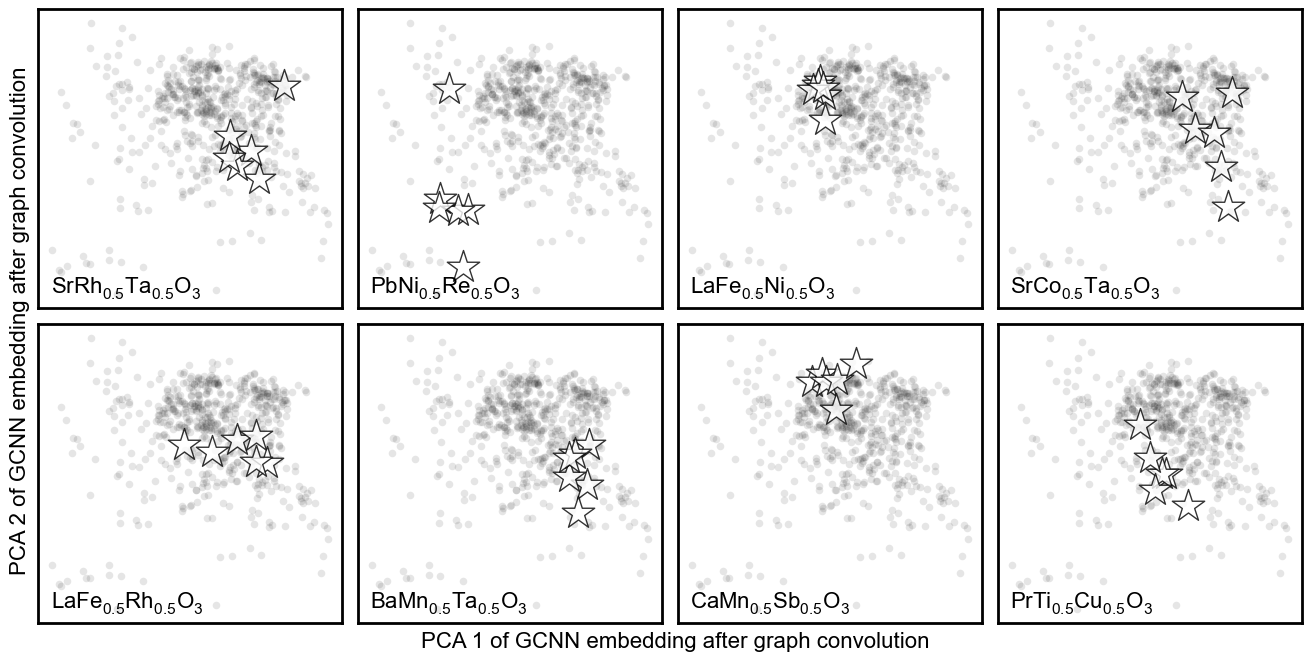

In [27]:
model_type = "e3nn"
struct_type = "relaxed"

fig = plt.figure(figsize=(13, 6.5), constrained_layout=True)
axes = fig.subplots(nrows=2, ncols=4, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

fig.supxlabel('PCA 1 of GCNN embedding after graph convolution', x=0.515, fontsize=16)
fig.supylabel('PCA 2 of GCNN embedding after graph convolution', y=0.515, fontsize=16)

for i in range(2):
    for j in range(4):
        ax_yaxis = axes[i][j].get_yaxis()
        ax_xaxis = axes[i][j].get_xaxis()
        ax_yaxis.set_visible(False)
        ax_xaxis.set_visible(False)
        axes[i][j].text(0.04, 0.05, selected_forms_formatted[i*4+j], horizontalalignment='left', fontsize=16, transform=axes[i][j].transAxes, color='black')
        plot_pca_embedding_additional(axes[i][j], model_type, struct_type, all_selected_forms[i*4+j])

# plt.tight_layout()
plt.savefig('./figures/SI_embedding_analysis_e3nn_relaxed.pdf', bbox_inches='tight')

# SI_dependence_interatomic_potentials

In [28]:
test_set = pd.read_json("./data/test_set.json")
ehull_test_true = flatten(test_set['dft_e_hull'])
ehull_test_M3GNet = flatten(test_set['M3Gnet_relaxed_energy_per_atom']) - flatten(test_set['dft_energy_per_atom']) + flatten(test_set['dft_e_hull'])
ehull_test_CHGNet = flatten(test_set['CHGNet_relaxed_energy_per_atom_corrected']) - flatten(test_set['dft_energy_per_atom']) + flatten(test_set['dft_e_hull'])
ehull_test_MACE = flatten(test_set['MACE_relaxed_energy_per_atom']) - flatten(test_set['dft_energy_per_atom']) + flatten(test_set['dft_e_hull'])

holdout_set_B_sites = pd.read_json("./data/holdout_set_B_sites.json")
diffs_dft = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.dft_e_hull)
diffs_M3GNet = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.M3Gnet_relaxed_energy_per_atom)
diffs_CHGNet = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.CHGNet_relaxed_energy_per_atom_corrected)
diffs_MACE = get_relative_vals(holdout_set_B_sites, holdout_set_B_sites.MACE_relaxed_energy_per_atom)

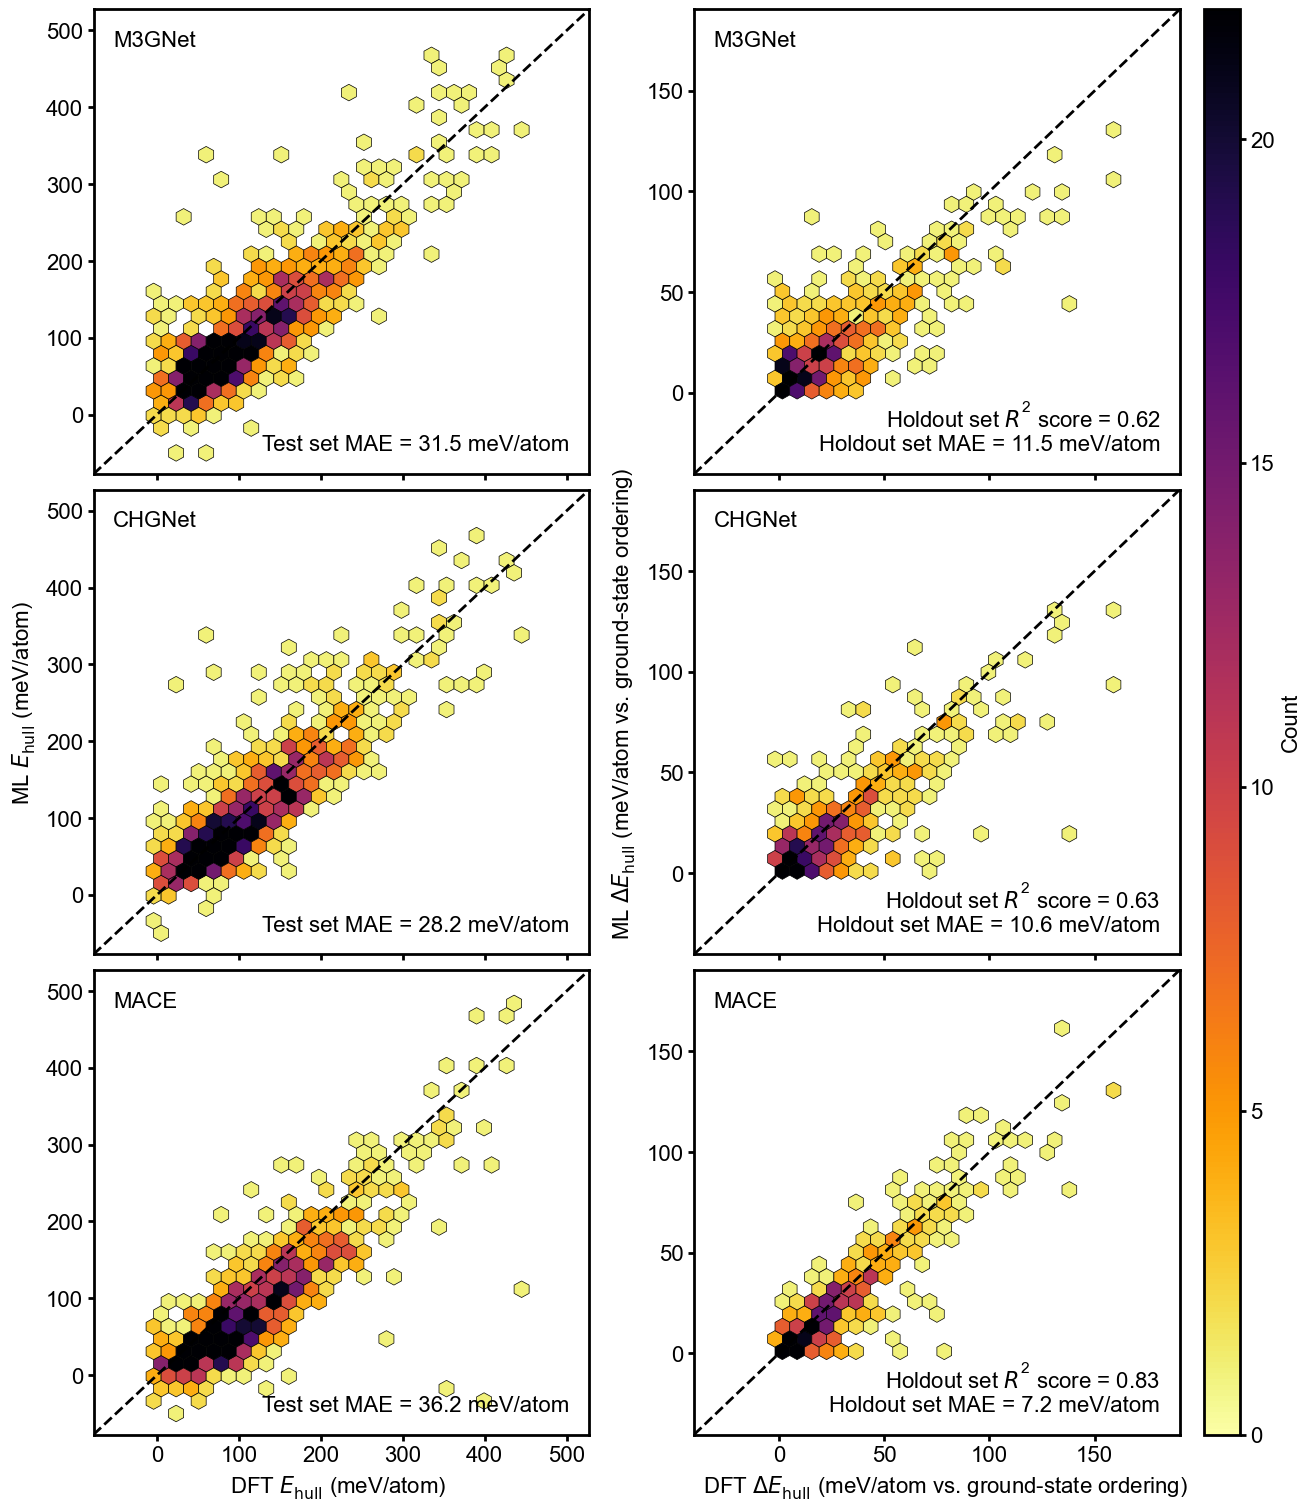

In [29]:
fig = plt.figure(figsize=(13, 15), constrained_layout=True)
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=[0.84, 1])
axes_l = subfig_l.subplots(nrows=3, ncols=1, sharex=True, sharey=True)
axes_r = subfig_r.subplots(nrows=3, ncols=1, sharex=True, sharey=True)

hex_cmap = 'inferno_r'
hex_gridsize = 30
hex_mincnt = 1
hex_edgecolors = 'black'
hex_linewidths = 0.5
cbar_vmax = 22

hex_xylim = [-50, 500]
axes_l[0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[0].hexbin(
    ehull_test_true*1000, ehull_test_M3GNet*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_l[0].text(0.04, 0.92, 'M3GNet', horizontalalignment='left', fontsize=16, transform=axes_l[0].transAxes)
axes_l[0].text(0.96, 0.05, 'Test set MAE = {:.1f} meV/atom'.format(mean_absolute_error(ehull_test_true, ehull_test_M3GNet)*1000), horizontalalignment='right', fontsize=16, transform=axes_l[0].transAxes)
axes_l[1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[1].hexbin(
    ehull_test_true*1000, ehull_test_CHGNet*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_l[1].text(0.04, 0.92, 'CHGNet', horizontalalignment='left', fontsize=16, transform=axes_l[1].transAxes)
axes_l[1].text(0.96, 0.05, 'Test set MAE = {:.1f} meV/atom'.format(mean_absolute_error(ehull_test_true, ehull_test_CHGNet)*1000), horizontalalignment='right', fontsize=16, transform=axes_l[1].transAxes)
axes_l[2].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_l[2].hexbin(
    ehull_test_true*1000, ehull_test_MACE*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_l[2].text(0.04, 0.92, 'MACE', horizontalalignment='left', fontsize=16, transform=axes_l[2].transAxes)
axes_l[2].text(0.96, 0.05, 'Test set MAE = {:.1f} meV/atom'.format(mean_absolute_error(ehull_test_true, ehull_test_MACE)*1000), horizontalalignment='right', fontsize=16, transform=axes_l[2].transAxes)
subfig_l.supxlabel('DFT $\mathit{E}_{\mathrm{hull}}$ (meV/atom)', x=0.565, fontsize=16)
subfig_l.supylabel('ML $\mathit{E}_{\mathrm{hull}}$ (meV/atom)', y=0.535, fontsize=16)

hex_xylim = [-30, 180]
axes_r[0].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_r[0].hexbin(
    diffs_dft*1000, diffs_M3GNet*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_r[0].text(0.04, 0.92, 'M3GNet', horizontalalignment='left', fontsize=16, transform=axes_r[0].transAxes)
axes_r[0].text(0.96, 0.05, 'Holdout set $\mathit{{R}}^2$ score = {:.2f}\nHoldout set MAE = {:.1f} meV/atom'.format(r2_score(diffs_dft, diffs_M3GNet), mean_absolute_error(diffs_dft, diffs_M3GNet)*1000), horizontalalignment='right', fontsize=16, transform=axes_r[0].transAxes)
axes_r[1].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
axes_r[1].hexbin(
    diffs_dft*1000, diffs_CHGNet*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_r[1].text(0.04, 0.92, 'CHGNet', horizontalalignment='left', fontsize=16, transform=axes_r[1].transAxes)
axes_r[1].text(0.96, 0.05, 'Holdout set $\mathit{{R}}^2$ score = {:.2f}\nHoldout set MAE = {:.1f} meV/atom'.format(r2_score(diffs_dft, diffs_CHGNet), mean_absolute_error(diffs_dft, diffs_CHGNet)*1000), horizontalalignment='right', fontsize=16, transform=axes_r[1].transAxes)
axes_r[2].axline((hex_xylim[0], hex_xylim[0]), (hex_xylim[1], hex_xylim[1]), color='black', linestyle='--', linewidth=2)
hex_example = axes_r[2].hexbin(
    diffs_dft*1000, diffs_MACE*1000,
    cmap=hex_cmap, gridsize=hex_gridsize, mincnt=hex_mincnt, edgecolors=hex_edgecolors, linewidths=hex_linewidths,
    extent=hex_xylim + hex_xylim, vmin=0, vmax=cbar_vmax,
)
axes_r[2].text(0.04, 0.92, 'MACE', horizontalalignment='left', fontsize=16, transform=axes_r[2].transAxes)
axes_r[2].text(0.96, 0.05, 'Holdout set $\mathit{{R}}^2$ score = {:.2f}\nHoldout set MAE = {:.1f} meV/atom'.format(r2_score(diffs_dft, diffs_MACE), mean_absolute_error(diffs_dft, diffs_MACE)*1000), horizontalalignment='right', fontsize=16, transform=axes_r[2].transAxes)

subfig_r.supxlabel('DFT $\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom vs. ground-state ordering)', x=0.485, fontsize=16)
subfig_r.supylabel('ML $\mathit{\Delta E}_{\mathrm{hull}}$ (meV/atom vs. ground-state ordering)', y=0.535, fontsize=16)

subfig_r.colorbar(hex_example, ax=axes_r, ticks=np.arange(0, cbar_vmax+1, 5), label='Count', aspect=40)

# plt.tight_layout()
plt.savefig('./figures/SI_dependence_interatomic_potentials.pdf', bbox_inches='tight')